IMPORTANTE: Para ejecutar correctamente este proyecto, debes tener una versión de Python soportada por Tensorflow. Nosotros estabamos usando la más reciente (3.11.1) y tuvimos que cambiar a la 3.9.11 para poder realizar el trabajo. Después, debes ejecutar el comando "pip install -r requirements.txt" desde la raíz del repositorio.

# MLE: Análisis de acciones empleando distintos algoritmos de aprendizaje.
Proyecto realizado por Carlos Núñez Arenas y José Antonio Zamudio Amaya.


## 0. Motivación

Las instituciones financieras de todo el mundo negocian a diario miles de millones de dólares. Empresas de inversión, fondos de cobertura e incluso particulares han estado utilizando modelos financieros para comprender mejor el comportamiento del mercado y realizar inversiones y operaciones rentables. Existe una gran cantidad de información disponible en forma de precios históricos de las acciones y datos sobre el rendimiento de las empresas, aptos para que los procesen los algoritmos de aprendizaje automático.

En este proyecto, crearemos un predictor del precio de las acciones de distintas macro-empresas, tomando como entrada los datos de negociación diaria de un determinado intervalo de fechas y para generar estimaciones proyectadas en determinadas fechas de consulta. Para esto, usaremos datos como el precio de apertura (Open), el precio más alto al que se negociaron las acciones (High), cuántas acciones se negociaron (Volume) y el precio de cierre ajustado por divisiones de acciones y dividendos (Adjusted Close), para cada día registrado en bolsa.

## 1. Carga de librerías y lectura del dataset
Vamos a leer los datasets de las acciones de Apple, Microsoft, Google, Amazon y Meta en el periodo 2018-2022, gracias a [Yahoo Finance](https://es.finance.yahoo.com/).

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [27]:
AAPL = pd.read_csv("./datasets/AAPL (2018-2022).csv")
MSFT = pd.read_csv("./datasets/MSFT (2018-2022).csv")
GOOG = pd.read_csv("./datasets/GOOG (2018-2022).csv")
AMZN = pd.read_csv("./datasets/AMZN (2018-2022).csv")
META = pd.read_csv("./datasets/META (2018-2022).csv")

AAPL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,40.950497,102223600
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,40.943352,118071600
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,41.133541,89738400
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,41.601864,94640000
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,41.447346,82271200


## 2. Preprocesamiento de los datasets

Vamos a desarrollar una función para formatear los datos para poder manejarlos mejor posteriormente. Para ello, hemos definido una función para reutilizarla con los 5 datasets, ya que tienen la misma estructura, número de filas y columnas y clases. Cambiamos las clases de las columnas.

In [28]:
def preprocessing(original_df):
    df = original_df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df['Open'] = df['Open'].astype('float')
    df['High'] = df['High'].astype('float')
    df['Low'] = df['Low'].astype('float')
    df['Close'] = df['Close'].astype('float')
    df['Adj Close'] = df['Adj Close'].astype('float')
    df['Volume'] = df['Volume'].astype('int')
    return df

PRE_AAPL = preprocessing(AAPL)
PRE_MSFT = preprocessing(MSFT)
PRE_GOOG = preprocessing(GOOG)
PRE_AMZN = preprocessing(AMZN)
PRE_META = preprocessing(META)

PRE_AAPL.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.950497,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.943352,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.133541,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.601864,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.447346,82271200


Vamos a calcular la correlación para cada dataset, a ver si podemos obtener información a priori:

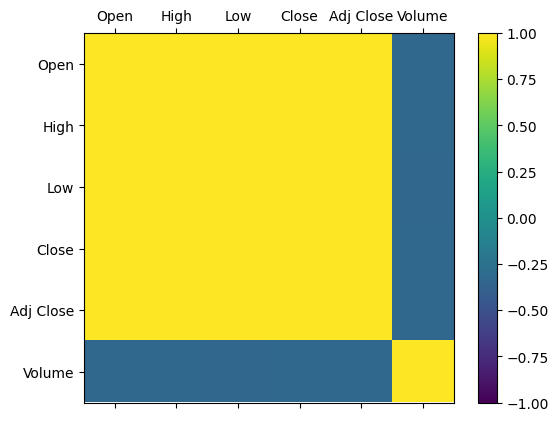

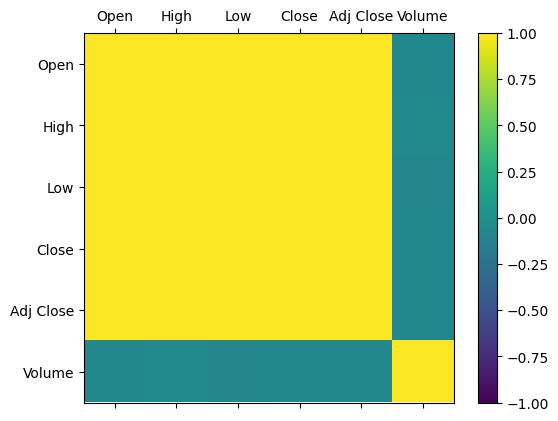

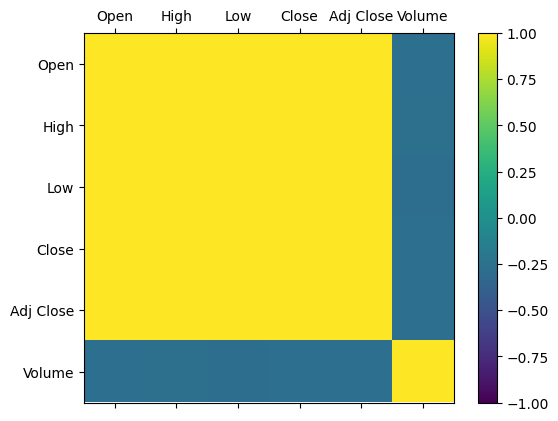

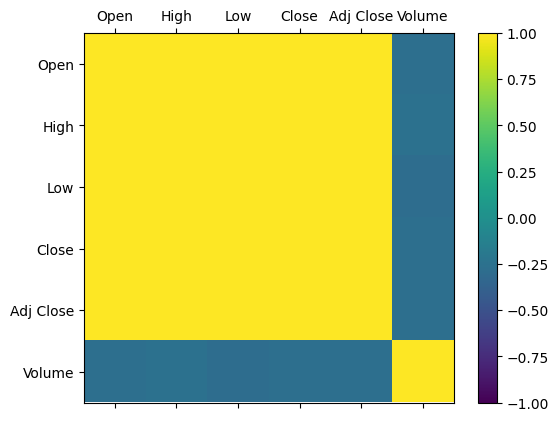

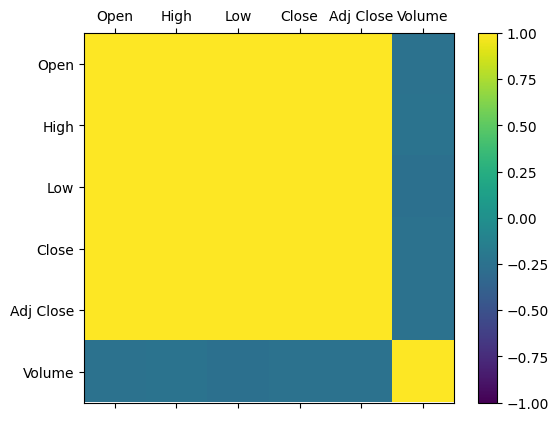

In [29]:
def correlation_analysis(original_df):
    df = original_df.copy()
    corr = df.corr()
    corr.style.background_gradient(cmap='coolwarm')
    # plot correlation matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, vmin=-1, vmax=1, interpolation='none')
    fig.colorbar(cax)
    ticks = np.arange(0,6,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.columns)
    plt.show()

correlation_analysis(PRE_AAPL)
correlation_analysis(PRE_MSFT)
correlation_analysis(PRE_GOOG)
correlation_analysis(PRE_AMZN)
correlation_analysis(PRE_META)

Teniendo en cuenta que el análisis de correlación se refiere al precio de las acciones, se puede 
concluir que el precio de apertura (Open), el precio máximo (High), el precio mínimo (Low), el precio de cierre 
(Close) y el precio de cierre ajustado (Adj Close) están altamente relacionados entre sí. Esto sugiere que el precio 
de las acciones varían de manera similar en relación a estas variables. Sin embargo, el volumen negociado 
de las acciones está inversamente relacionado con el resto de las variables. Esto podría indicar 
que cuando el volumen de negociación es alto, el precio de las acciones de las compaías estudiadas tienden a disminuir, por ley
de oferta y demanda.

Ahora, vamos a calcular varias estadísticas relevantes para cada una de los datasets, que nos servirán posteriormente 
para obtener información sobre las bandas de Bollinger.

In [33]:
def compute_stats(original_df):
    df = original_df.copy()
    df['close_daily_change'] = df['Close'].pct_change()
    df['30d_ma'] = df['Close'].rolling(window=30).mean()
    df['30d_std'] = df['Close'].rolling(window=30).std()
    df['upper_band'] = df['30d_ma'] + 2 * df['30d_std']
    df['lower_band'] = df['30d_ma'] - 2 * df['30d_std']
    df['rolling_mean'] = df['Close'].rolling(window=30).mean()
    df['rolling_std'] = df['Close'].rolling(window=30).std()
    df['daily_range'] = df['High'] - df['Low']
    df['P/E'] = df['Close'] / df['Adj Close']
    df['30d_volatility'] = df['close_daily_change'].rolling(window=30).std()
    df['30d_avg_volume'] = df['Volume'].rolling(window=30).mean()
    df['30d_avg_daily_range'] = df['daily_range'].rolling(window=30).mean()
    df['30d_avg_close_daily_change'] = df['close_daily_change'].rolling(window=30).mean()
    df['30d_avg_daily_volatility'] = df['30d_volatility'].rolling(window=30).mean()
    df['30d_avg_P/E'] = df['P/E'].rolling(window=30).mean()
    return df

COMP_AAPL = compute_stats(PRE_AAPL)
COMP_MSFT = compute_stats(PRE_MSFT)
COMP_GOOG = compute_stats(PRE_GOOG)
COMP_AMZN = compute_stats(PRE_AMZN)
COMP_META = compute_stats(PRE_META)

## 3. Visualización de valores relevantes de los datasets

Vamos a visualizar la evolución del valor de cierre de mercado diario de cada compañía, y además el rango de retorno en base a su frecuencia.

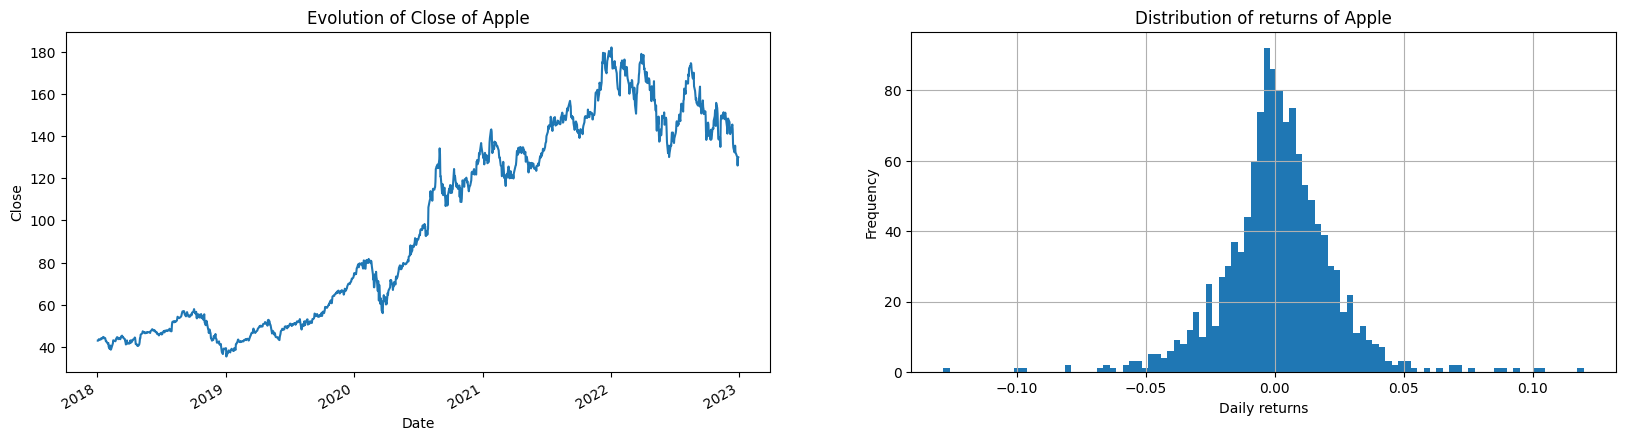

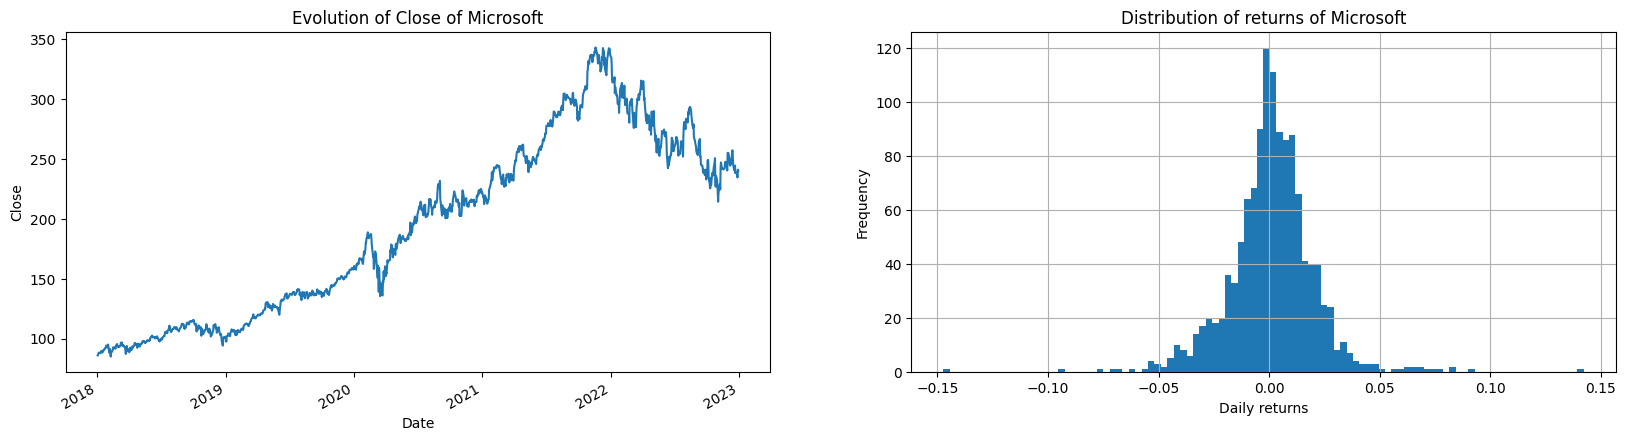

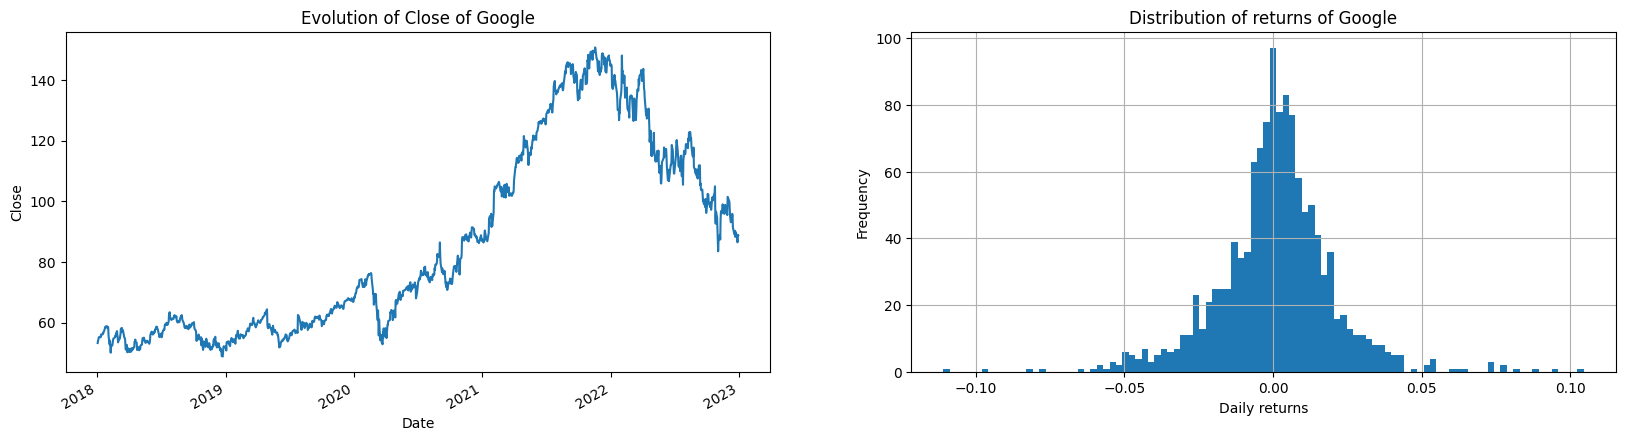

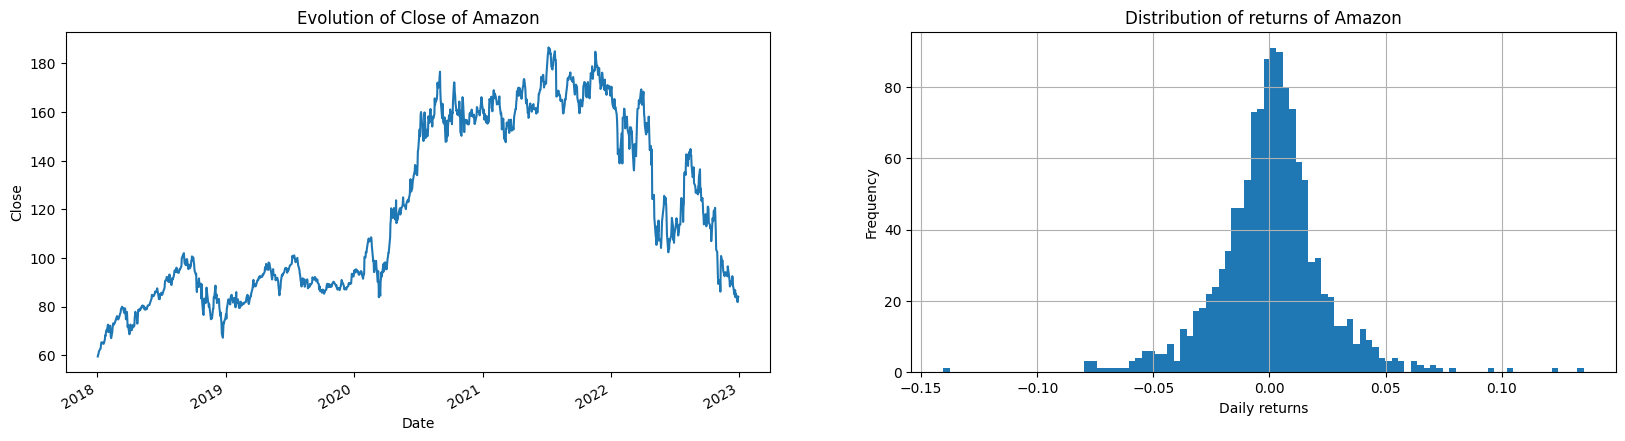

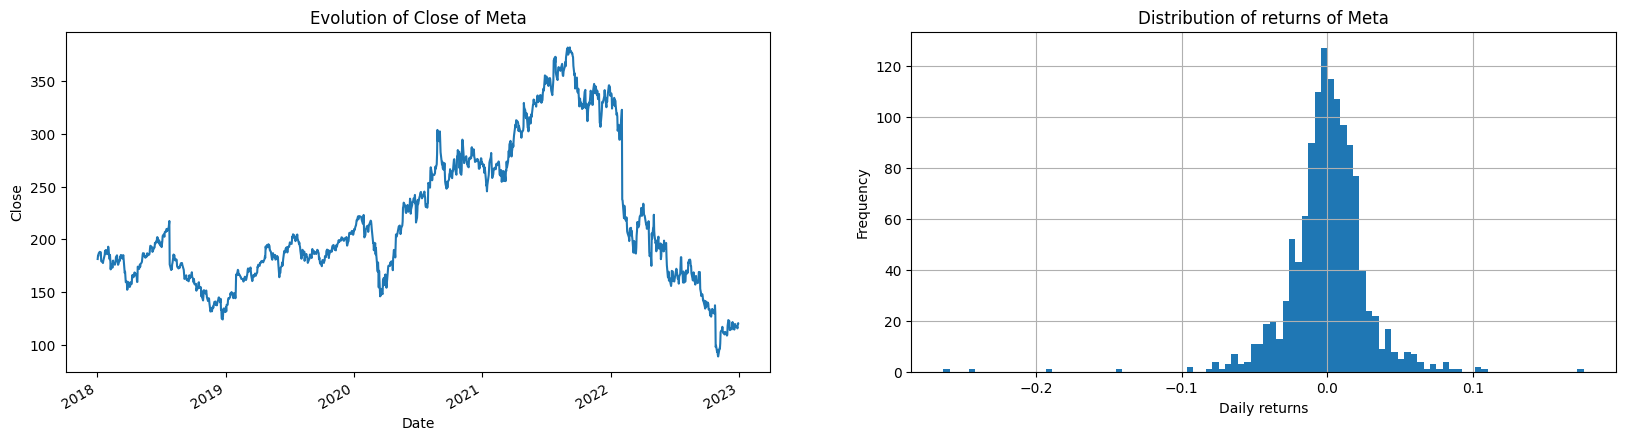

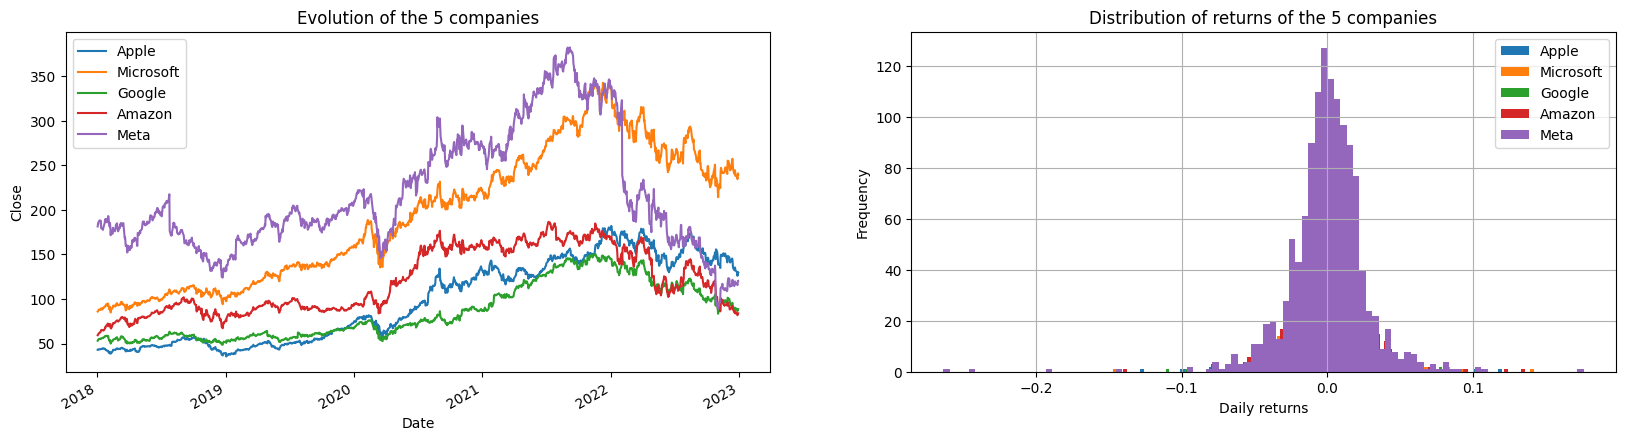

In [34]:
def visualize_evolution(original_df, column, company):
    df = original_df.copy()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    df[column].plot(ax=axes[0])
    axes[0].set_title("Evolution of " + column + " of " + company)
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel(column)
    df[column + '_daily_change'] = df[column].pct_change()
    df[column + '_daily_change'].hist(ax=axes[1], bins=100)
    axes[1].set_title("Distribution of returns of " + company)
    axes[1].set_xlabel("Daily returns")
    axes[1].set_ylabel("Frequency")
    plt.show()

visualize_evolution(PRE_AAPL, 'Close', 'Apple')
visualize_evolution(PRE_MSFT, 'Close', 'Microsoft')
visualize_evolution(PRE_GOOG, 'Close', 'Google')
visualize_evolution(PRE_AMZN, 'Close', 'Amazon')
visualize_evolution(PRE_META, 'Close', 'Meta')

# visualize the 5 datasets[close] in one plot, to see the evolution of the 5 companies, with different colors y un label para cada una
def visualize_evolution_all(original_df1, original_df2, original_df3, original_df4, original_df5):
    df1 = original_df1.copy()
    df2 = original_df2.copy()
    df3 = original_df3.copy()
    df4 = original_df4.copy()
    df5 = original_df5.copy()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    df1['Close'].plot(ax=axes[0], label='Apple')
    df2['Close'].plot(ax=axes[0], label='Microsoft')
    df3['Close'].plot(ax=axes[0], label='Google')
    df4['Close'].plot(ax=axes[0], label='Amazon')
    df5['Close'].plot(ax=axes[0], label='Meta')
    axes[0].set_title("Evolution of the 5 companies")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Close")
    axes[0].legend()
    df1['Close_daily_change'] = df1['Close'].pct_change()
    df1['Close_daily_change'].hist(ax=axes[1], bins=100, label='Apple')
    df2['Close_daily_change'] = df2['Close'].pct_change()
    df2['Close_daily_change'].hist(ax=axes[1], bins=100, label='Microsoft')
    df3['Close_daily_change'] = df3['Close'].pct_change()
    df3['Close_daily_change'].hist(ax=axes[1], bins=100, label='Google')
    df4['Close_daily_change'] = df4['Close'].pct_change()
    df4['Close_daily_change'].hist(ax=axes[1], bins=100, label='Amazon')
    df5['Close_daily_change'] = df5['Close'].pct_change()
    df5['Close_daily_change'].hist(ax=axes[1], bins=100, label='Meta')
    axes[1].set_title("Distribution of returns of the 5 companies")
    axes[1].set_xlabel("Daily returns")
    axes[1].set_ylabel("Frequency")
    axes[1].legend()
    plt.show()

visualize_evolution_all(PRE_AAPL, PRE_MSFT, PRE_GOOG, PRE_AMZN, PRE_META)


Ahora vamos a realizar un análisis según bandas de Bollinger. Las bandas de Bollinger son un indicador técnico utilizado en análisis financiero para evaluar la volatilidad de un activo. Estas bandas son dos líneas trazadas en un gráfico de precios, una por encima y otra por debajo de una media móvil, y se utilizan para representar una desviación estándar del precio. Con estas gráficas, podemos identificar patrones de comportamiento de los precios y evaluar la volatilidad del mercado, lo que nos puede servir para tomar decisiones informadas sobre la compra y venta de acciones a futuro. 

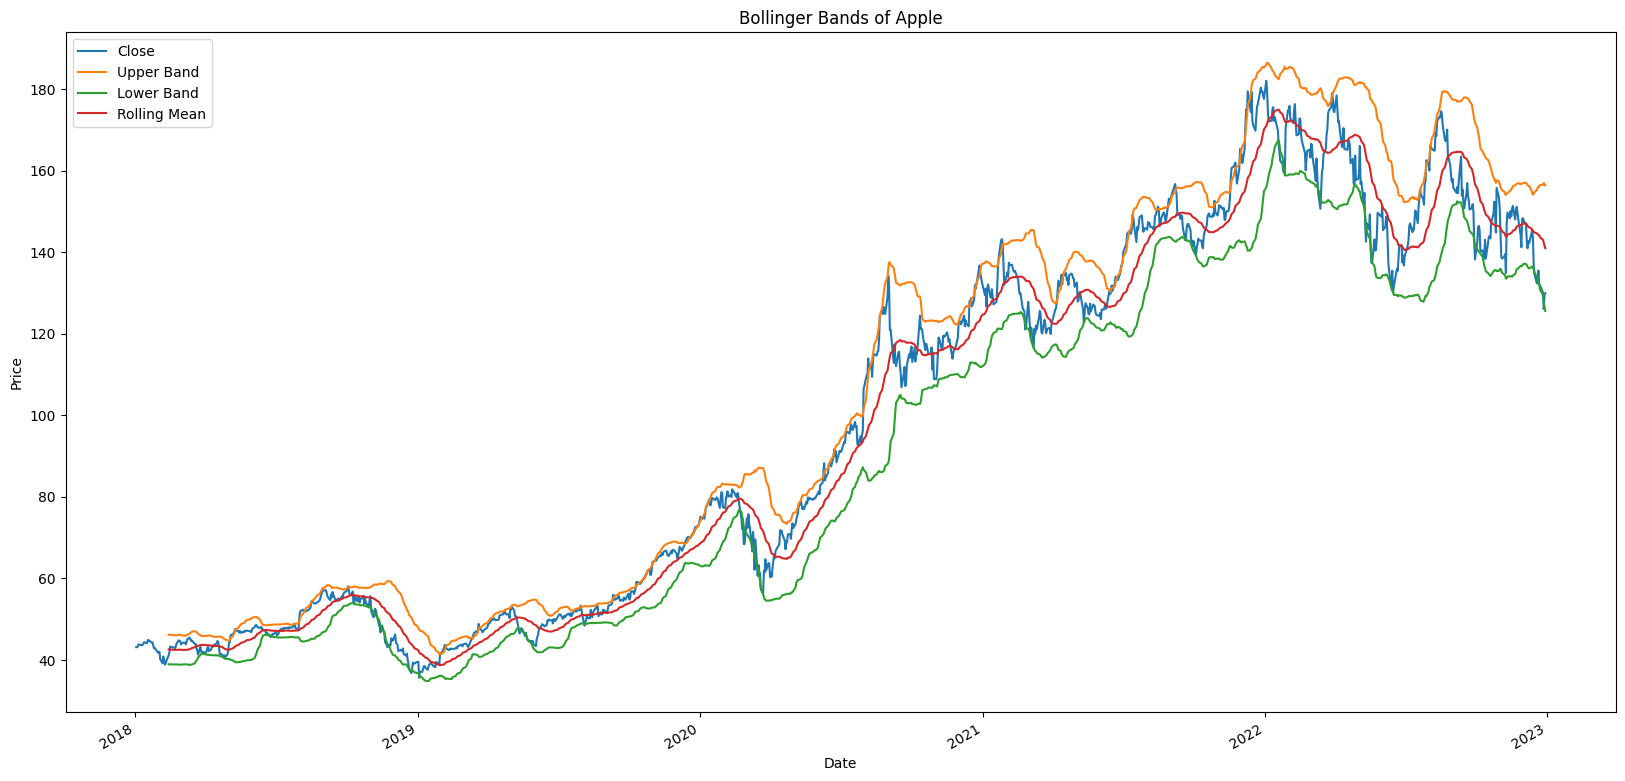

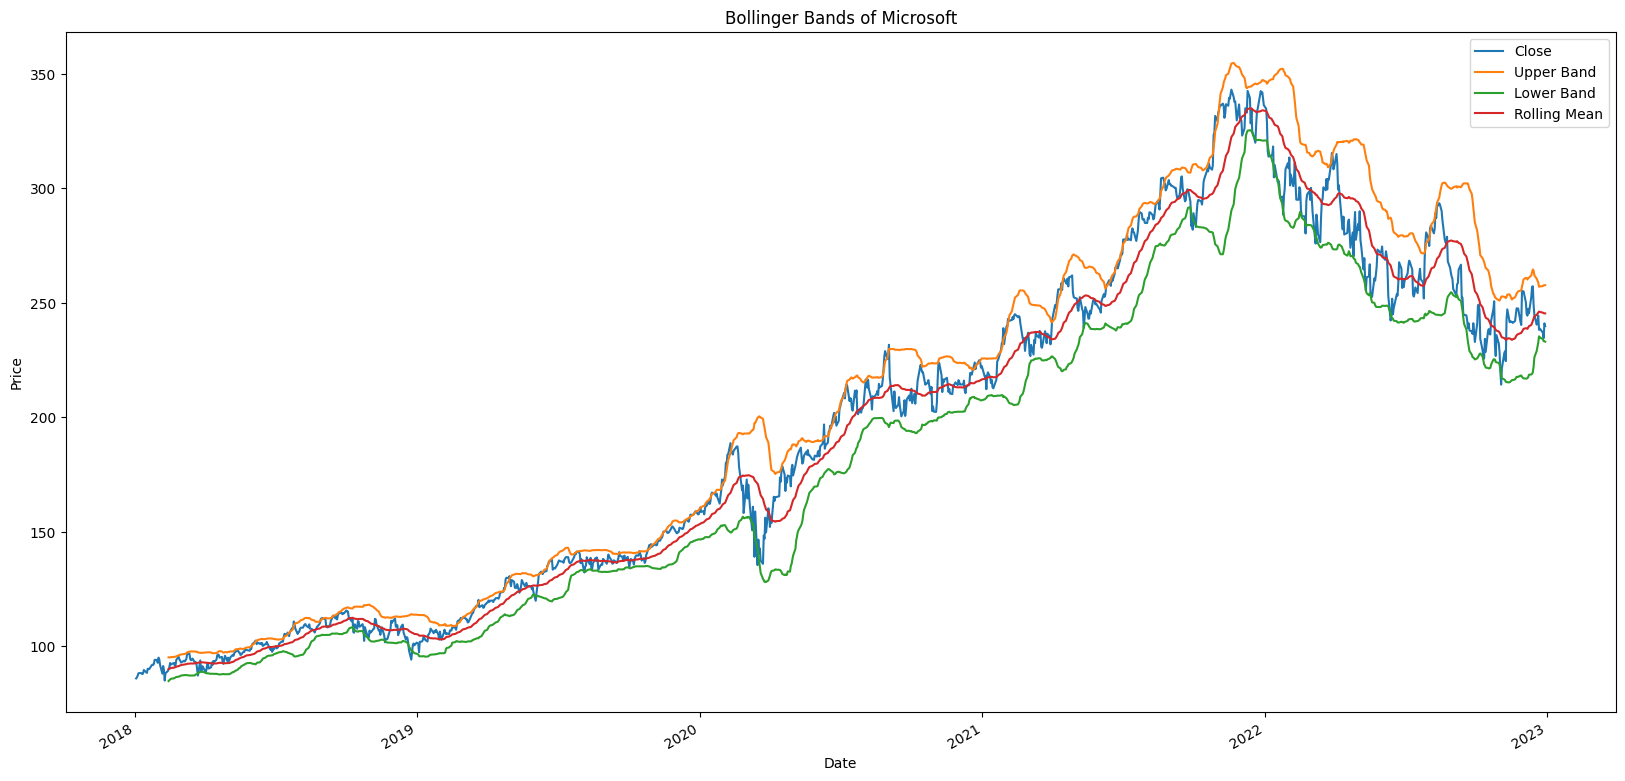

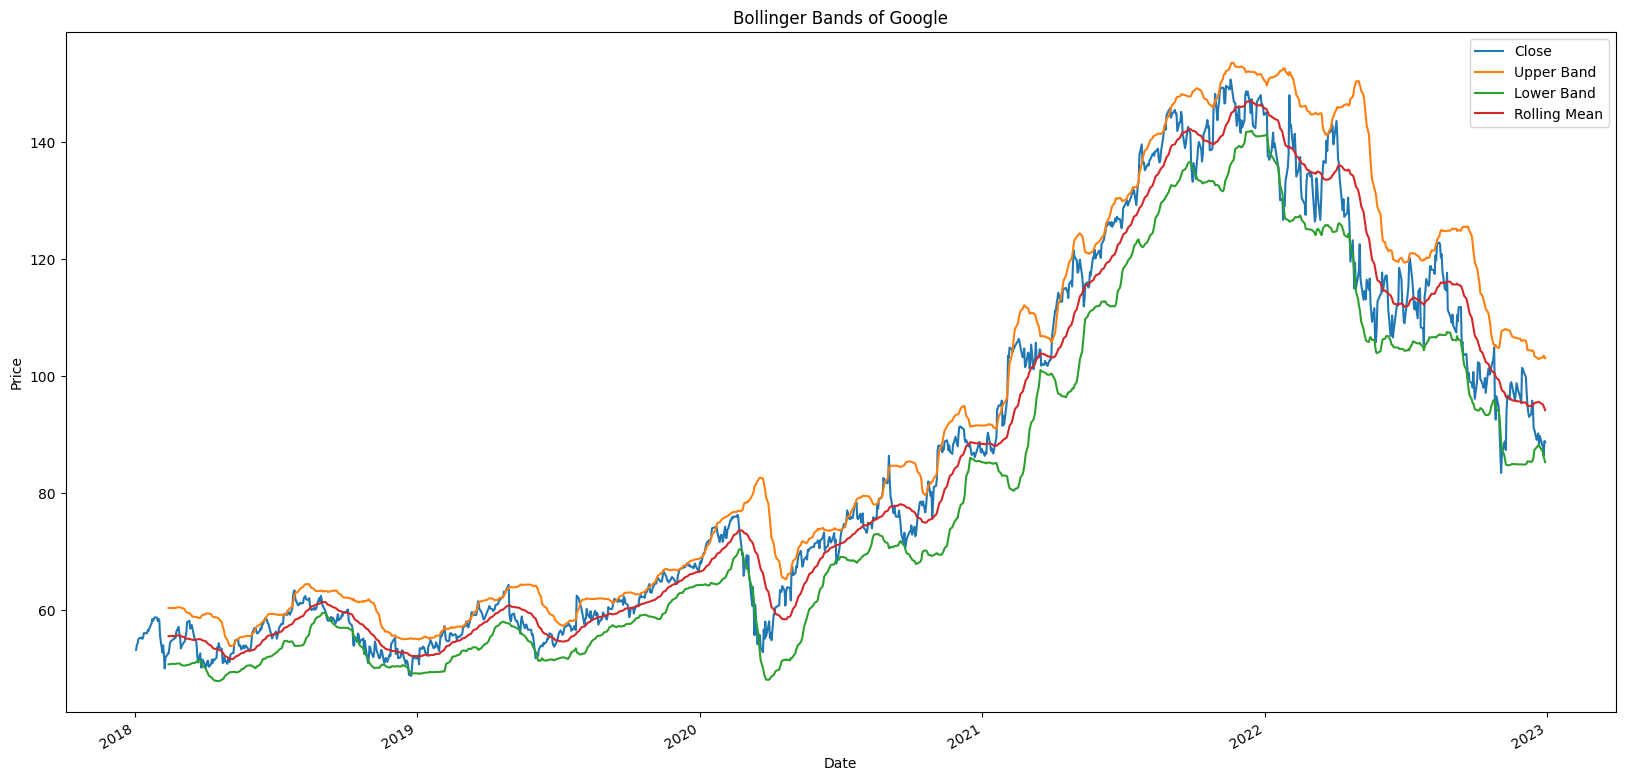

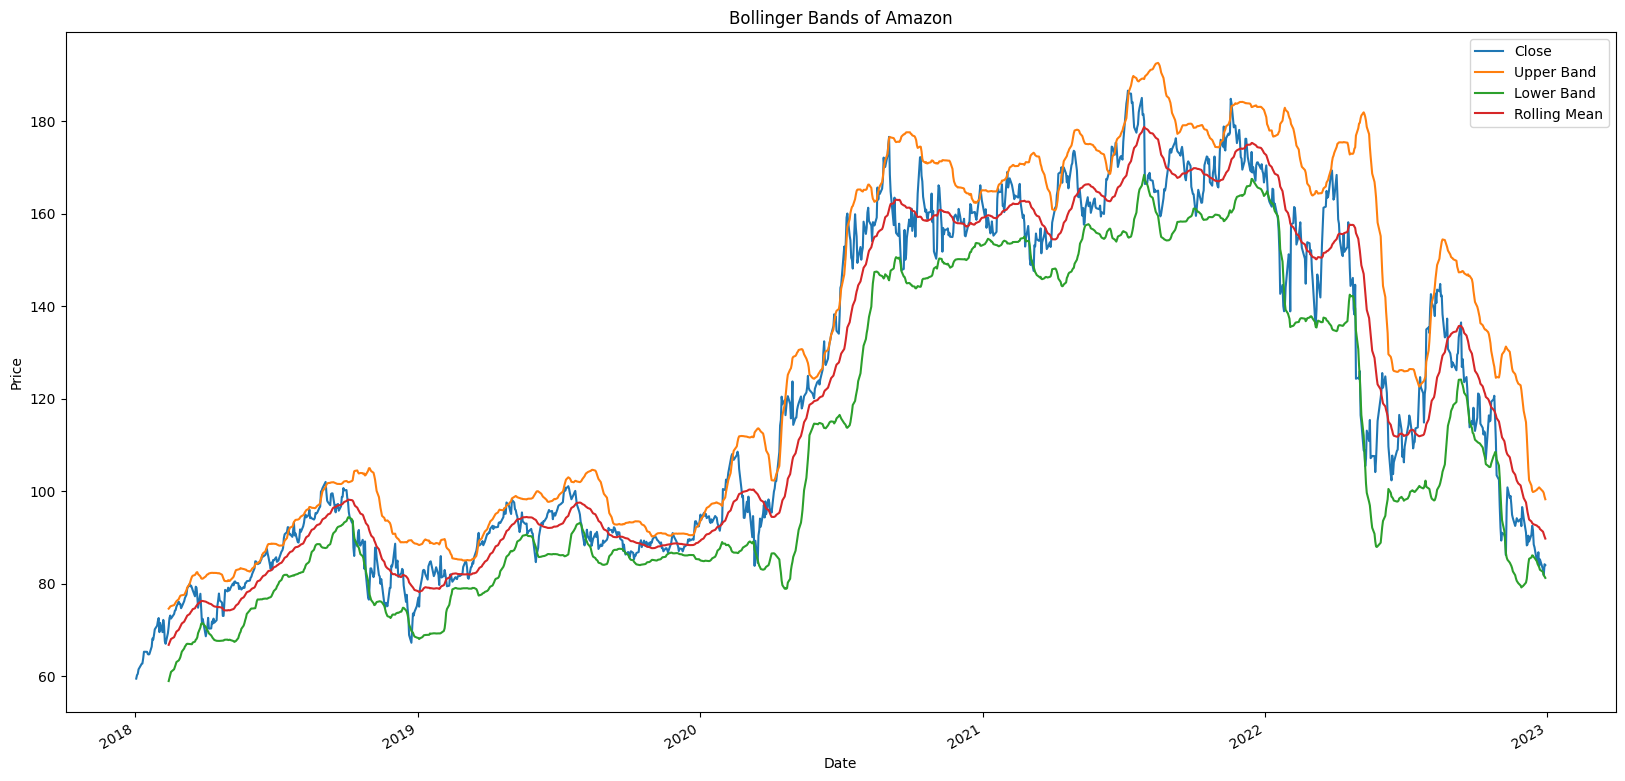

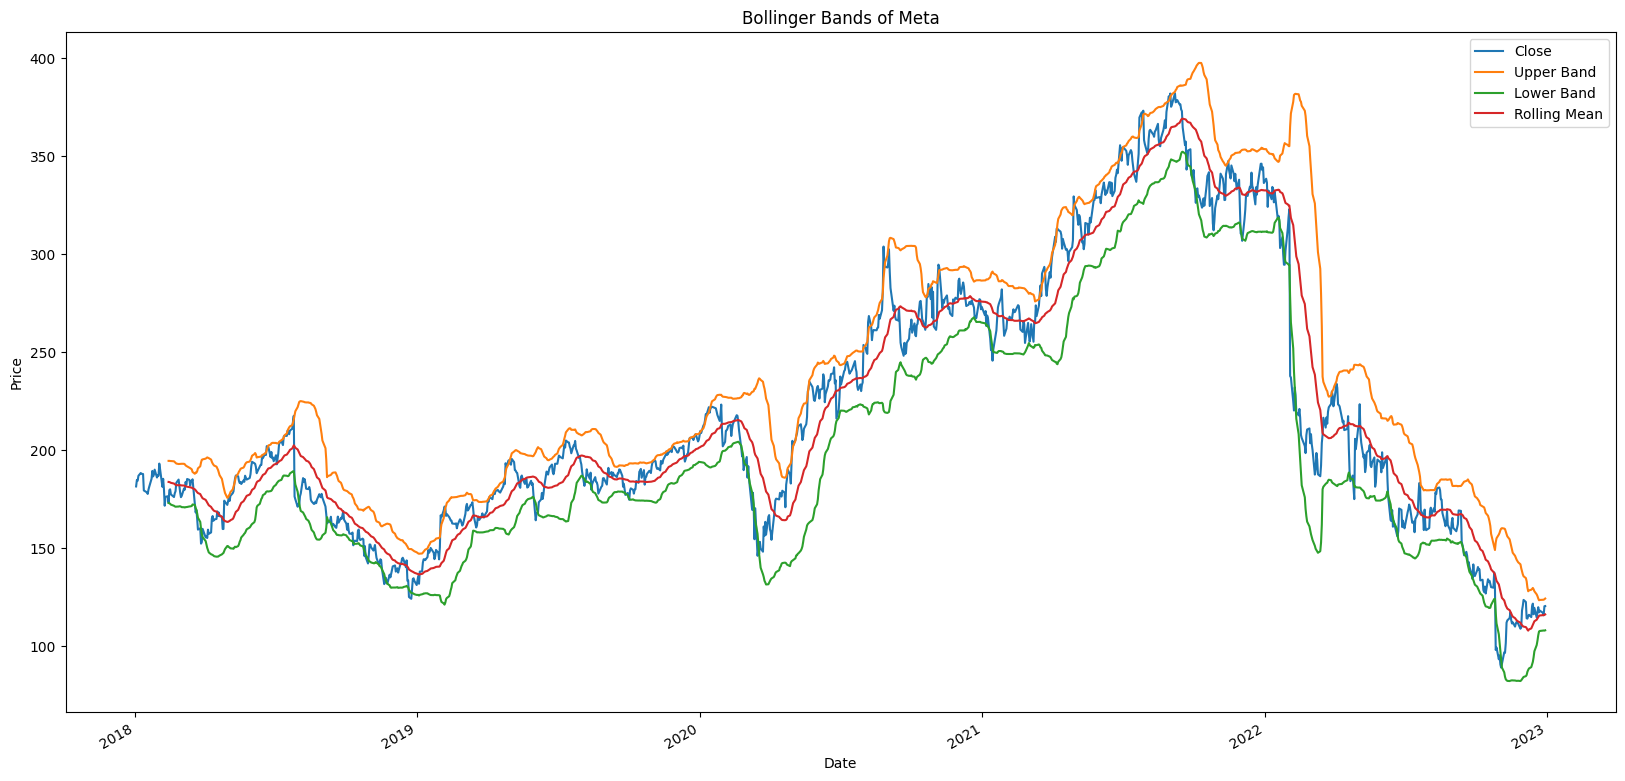

In [38]:
def show_bollinger_bands(original_df, company):
    df = original_df.copy()
    df['Close'].plot(figsize=(20,10), label='Close')
    df['upper_band'].plot(label='Upper Band')
    df['lower_band'].plot(label='Lower Band')
    df['rolling_mean'].plot(label='Rolling Mean')
    plt.legend(loc='best')
    plt.title("Bollinger Bands of " + company)
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.show()

show_bollinger_bands(COMP_AAPL, 'Apple')
show_bollinger_bands(COMP_MSFT, 'Microsoft')
show_bollinger_bands(COMP_GOOG, 'Google')
show_bollinger_bands(COMP_AMZN, 'Amazon')
show_bollinger_bands(COMP_META, 'Meta')

Bollinger observó que si observamos la volatilidad reciente de la acción, si es muy volátil, podríamos descartar el movimiento por encima y por debajo de la media. Pero si no es muy volátil, podemos prestarle atención. La media móvil puede darnos una idea de los verdaderos precios subyacentes de una acción. Si hay una desviación significativa por debajo o por encima de la media móvil, puede darnos una idea sobre una posible oportunidad de compra o venta, respectivamente. El reto sigue siendo saber cuándo esta desviación es lo suficientemente significativa como para prestarle atención. 

## 4. Entrenamiento de distintos modelos predictores y evaluación

Vamos a entrenar varios modelos de predicción para intentar predecir el valor de cierre de un stock en el futuro, para posteriomente evaluar los modelos y quedarnos con el que mejor se ajuste.

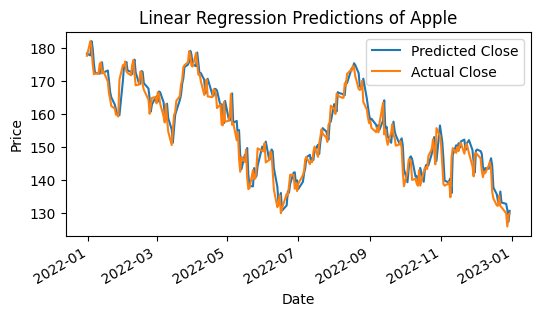

Linear Regression RMSE of Apple: 3.5061446192643757


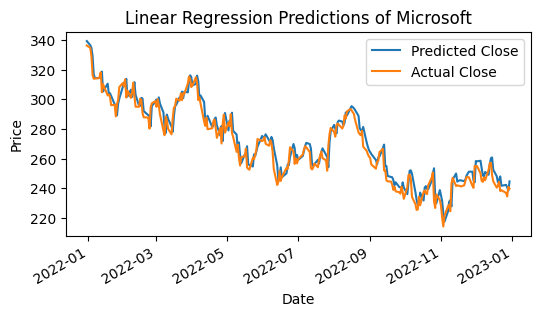

Linear Regression RMSE of Microsoft: 6.412552192699613


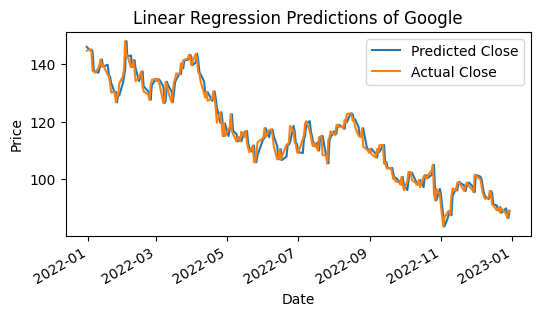

Linear Regression RMSE of Google: 2.7845607696708226


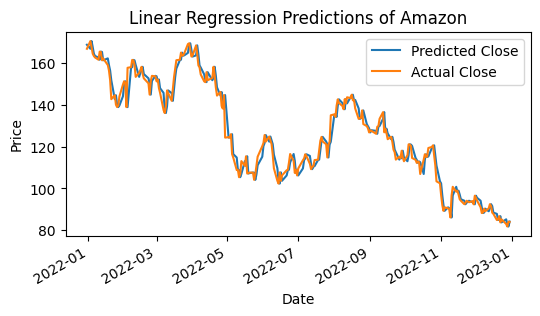

Linear Regression RMSE of Amazon: 3.9748856179796066


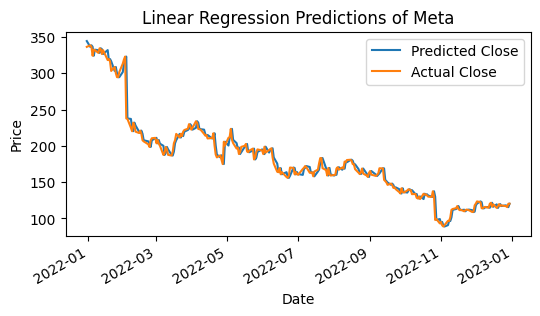

Linear Regression RMSE of Meta: 8.307702826010754


In [39]:
def train_with_linear_regression(original_df, company):
    df = original_df.copy()
    train, test = train_test_split(df, test_size=0.2, shuffle=False)
    X_train = train.drop(['Close'], axis=1)
    y_train = train['Close']
    X_test = test.drop(['Close'], axis=1)
    y_test = test['Close']

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
    lr_pred = pd.DataFrame(lr_pred, index=y_test.index, columns=['Close'])
    lr_pred['Close'] = lr_pred['Close'].shift(1)
    lr_pred['Close'].iloc[0] = y_train.iloc[-1]
    lr_pred['Close'].plot(figsize=(6,3), label='Predicted Close')
    y_test.plot(label='Actual Close')
    plt.legend(loc='best')
    plt.title("Linear Regression Predictions of " + company)
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.show()
    lf_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
    print("Linear Regression RMSE of " + company + ": " + str(lf_rmse))
    return [lr, lf_rmse]

LR_AAPL = train_with_linear_regression(PRE_AAPL, 'Apple')
LR_MSFT = train_with_linear_regression(PRE_MSFT, 'Microsoft')
LR_GOOG = train_with_linear_regression(PRE_GOOG, 'Google')
LR_AMZN = train_with_linear_regression(PRE_AMZN, 'Amazon')
LR_META = train_with_linear_regression(PRE_META, 'Meta')

Vamos a usar ahora modelos de Random Forest:

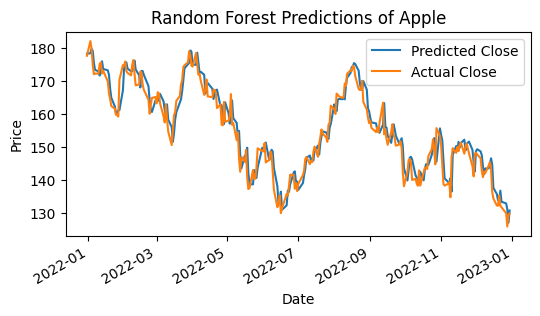

Random Forest RMSE of Apple: 3.5864205194786627


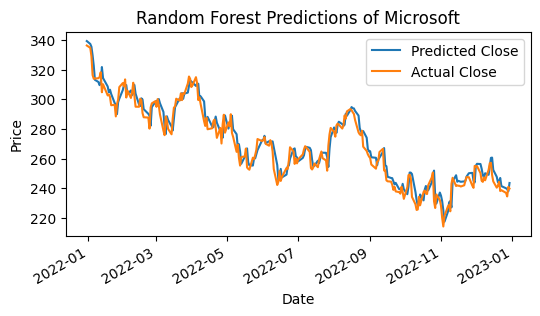

Random Forest RMSE of Microsoft: 6.240462683145402


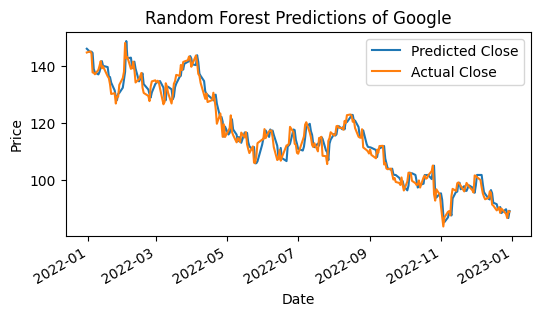

Random Forest RMSE of Google: 2.908067892255273


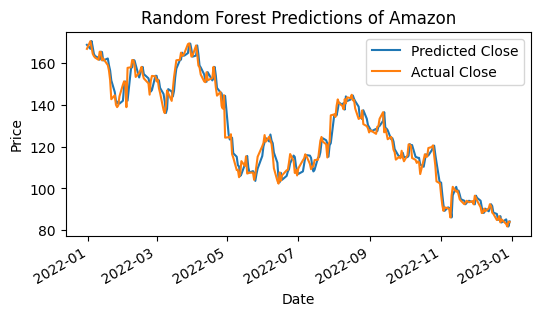

Random Forest RMSE of Amazon: 4.043917551184271


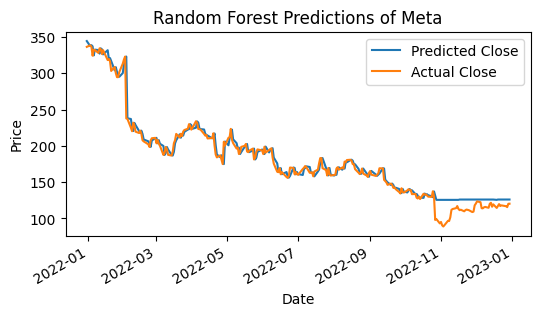

Random Forest RMSE of Meta: 10.878386621294492


In [40]:
def train_with_random_forest(original_df, company):
    df = original_df.copy()
    train, test = train_test_split(df, test_size=0.2, shuffle=False)
    X_train = train.drop(['Close'], axis=1)
    y_train = train['Close']
    X_test = test.drop(['Close'], axis=1)
    y_test = test['Close']

    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_pred = pd.DataFrame(rf_pred, index=y_test.index, columns=['Close'])
    rf_pred['Close'] = rf_pred['Close'].shift(1)
    rf_pred['Close'].iloc[0] = y_train.iloc[-1]
    rf_pred['Close'].plot(figsize=(6,3), label='Predicted Close')
    y_test.plot(label='Actual Close')
    plt.legend(loc='best')
    plt.title("Random Forest Predictions of " + company)
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.show()
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
    print("Random Forest RMSE of " + company + ": " + str(rf_rmse))
    return [rf, rf_rmse]

RF_AAPL = train_with_random_forest(PRE_AAPL, 'Apple')
RF_MSFT = train_with_random_forest(PRE_MSFT, 'Microsoft')
RF_GOOG = train_with_random_forest(PRE_GOOG, 'Google')
RF_AMZN = train_with_random_forest(PRE_AMZN, 'Amazon')
RF_META = train_with_random_forest(PRE_META, 'Meta')

Vamos a aplicar LSTM:

8/8 [==============================] - 0s 2ms/step


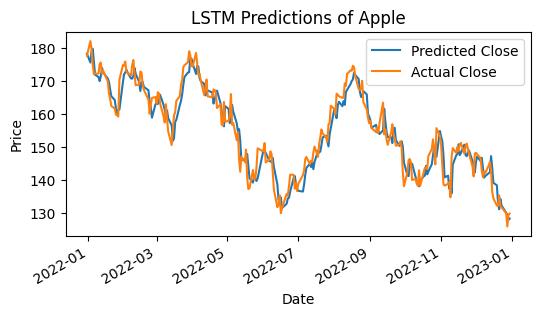

LSTM RMSE of Apple: 3.803987926422642
8/8 [==============================] - 0s 1ms/step


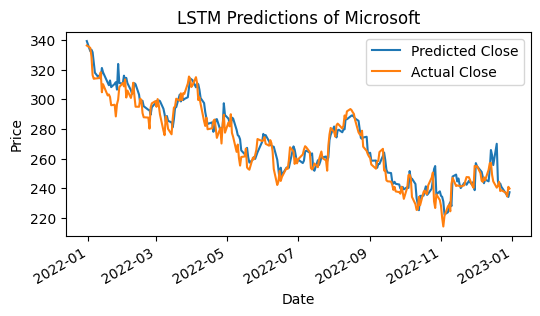

LSTM RMSE of Microsoft: 7.648324079478173
8/8 [==============================] - 0s 2ms/step


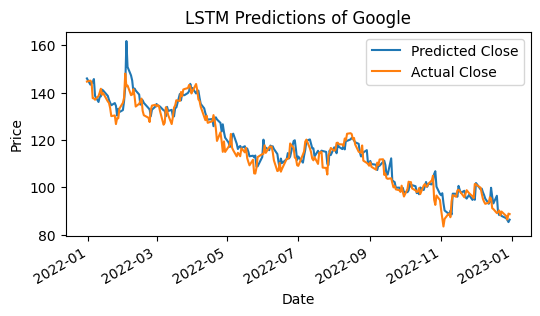

LSTM RMSE of Google: 3.8981240852362924
8/8 [==============================] - 0s 2ms/step


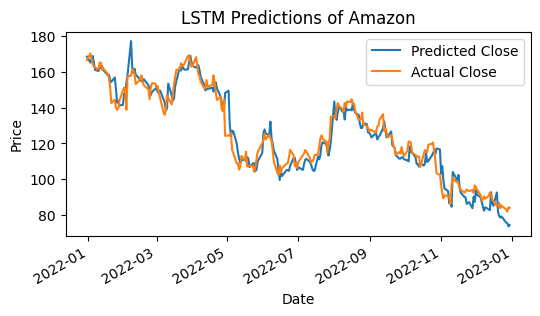

LSTM RMSE of Amazon: 5.938766247860455
8/8 [==============================] - 0s 2ms/step


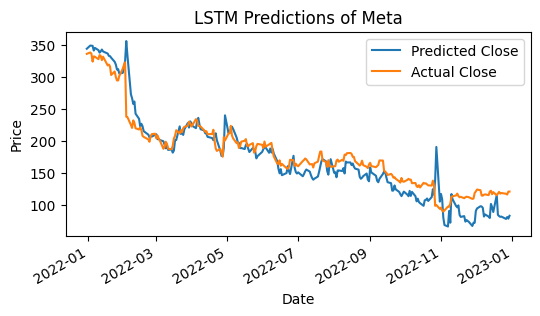

LSTM RMSE of Meta: 22.081988755424536


In [11]:
def train_with_lstm(original_df, company):
    df = original_df.copy()
    train, test = train_test_split(df, test_size=0.2, shuffle=False)
    X_train = train.drop(['Close'], axis=1)
    y_train = train['Close']
    X_test = test.drop(['Close'], axis=1)
    y_test = test['Close']

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    lstm = Sequential()
    lstm.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[2])))
    lstm.add(Dense(1))
    lstm.compile(optimizer='adam', loss='mse')
    lstm.fit(X_train, y_train, epochs=100, verbose=0)

    lstm_pred = lstm.predict(X_test)
    lstm_pred = pd.DataFrame(lstm_pred, index=y_test.index, columns=['Close'])
    lstm_pred['Close'] = lstm_pred['Close'].shift(1)
    lstm_pred['Close'].iloc[0] = y_train.iloc[-1]
    lstm_pred['Close'].plot(figsize=(6,3), label='Predicted Close')
    y_test.plot(label='Actual Close')
    plt.legend(loc='best')
    plt.title("LSTM Predictions of " + company)
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.show()
    lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
    print("LSTM RMSE of " + company + ": " + str(lstm_rmse))
    return [lstm, lstm_rmse]

LSTM_AAPL = train_with_lstm(PRE_AAPL, 'Apple')
LSTM_MSFT = train_with_lstm(PRE_MSFT, 'Microsoft')
LSTM_GOOG = train_with_lstm(PRE_GOOG, 'Google')
LSTM_AMZN = train_with_lstm(PRE_AMZN, 'Amazon')
LSTM_META = train_with_lstm(PRE_META, 'Meta')

Como último modelo vamos a utilizar XGBoost:

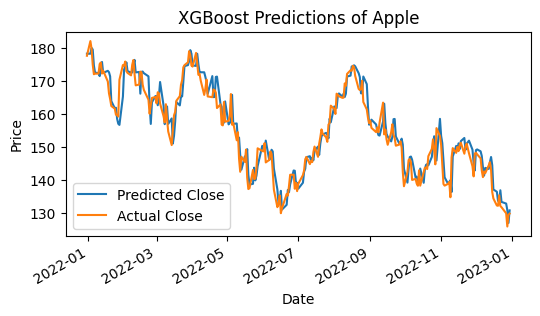

XGBoost RMSE of Apple: 3.8255961575253337


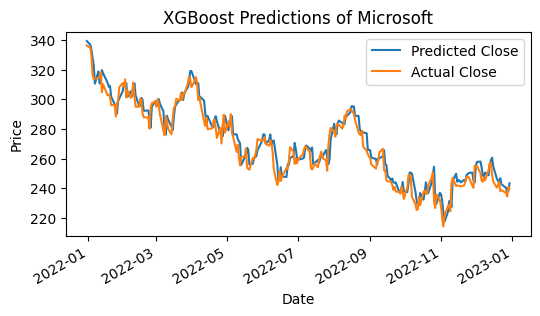

XGBoost RMSE of Microsoft: 6.716108888128521


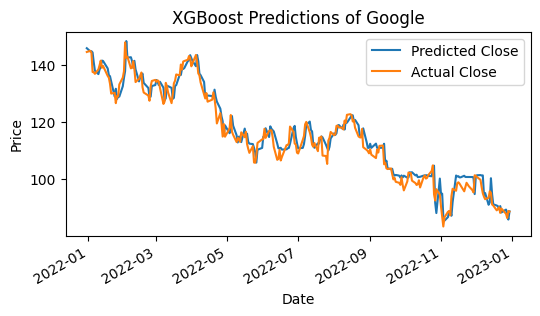

XGBoost RMSE of Google: 3.181239478673544


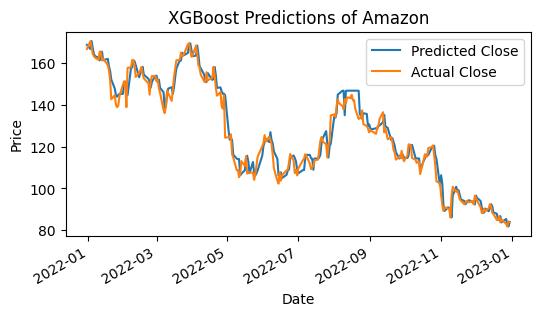

XGBoost RMSE of Amazon: 4.315404289659156


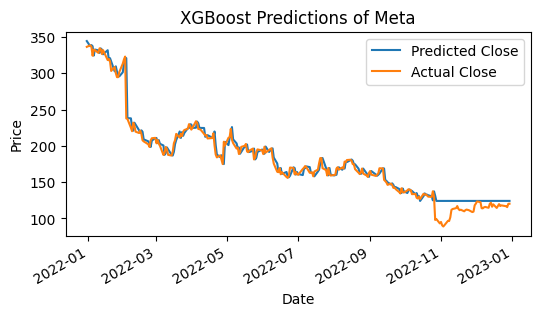

XGBoost RMSE of Meta: 10.528459027456087


In [13]:
def train_with_xgboost(original_df, company):
    df = original_df.copy()
    train, test = train_test_split(df, test_size=0.2, shuffle=False)
    X_train = train.drop(['Close'], axis=1)
    y_train = train['Close']
    X_test = test.drop(['Close'], axis=1)
    y_test = test['Close']

    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_pred = pd.DataFrame(xgb_pred, index=y_test.index, columns=['Close'])
    xgb_pred['Close'] = xgb_pred['Close'].shift(1)
    xgb_pred['Close'].iloc[0] = y_train.iloc[-1]
    xgb_pred['Close'].plot(figsize=(6,3), label='Predicted Close')
    y_test.plot(label='Actual Close')
    plt.legend(loc='best')
    plt.title("XGBoost Predictions of " + company)
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.show()
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
    print("XGBoost RMSE of " + company + ": " + str(xgb_rmse))
    return [xgb, xgb_rmse]

XGB_AAPL = train_with_xgboost(PRE_AAPL, 'Apple')
XGB_MSFT = train_with_xgboost(PRE_MSFT, 'Microsoft')
XGB_GOOG = train_with_xgboost(PRE_GOOG, 'Google')
XGB_AMZN = train_with_xgboost(PRE_AMZN, 'Amazon')
XGB_META = train_with_xgboost(PRE_META, 'Meta')

Con 4 modelos entrenados y evaluados, podemos ver que los resultados difieren bastante entre sí. Vamos a quedarnos con el mejor modelo para cada compañia.

In [14]:
BEST_AAPL = min(LR_AAPL[1], RF_AAPL[1], LSTM_AAPL[1], XGB_AAPL[1])
if BEST_AAPL == LR_AAPL[1]:
    print("Best model for Apple is Linear Regression")
    BEST_AAPL = LR_AAPL[0]
elif BEST_AAPL == RF_AAPL[1]:
    print("Best model for Apple is Random Forest")
    BEST_AAPL = RF_AAPL[0]
elif BEST_AAPL == LSTM_AAPL[1]:
    print("Best model for Apple is LSTM")
    BEST_AAPL = LSTM_AAPL[0]
else:
    print("Best model for Apple is XGBoost")
    BEST_AAPL = XGB_AAPL[0]

BEST_MSFT = min(LR_MSFT[1], RF_MSFT[1], LSTM_MSFT[1], XGB_MSFT[1])
if BEST_MSFT == LR_MSFT[1]:
    print("Best model for Microsoft is Linear Regression")
    BEST_MSFT = LR_MSFT[0]
elif BEST_MSFT == RF_MSFT[1]:
    print("Best model for Microsoft is Random Forest")
    BEST_MSFT = RF_MSFT[0]
elif BEST_MSFT == LSTM_MSFT[1]:
    print("Best model for Microsoft is LSTM")
    BEST_MSFT = LSTM_MSFT[0]
else:
    print("Best model for Microsoft is XGBoost")
    BEST_MSFT = XGB_MSFT[0]

BEST_GOOG = min(LR_GOOG[1], RF_GOOG[1], LSTM_GOOG[1], XGB_GOOG[1])
if BEST_GOOG == LR_GOOG[1]:
    print("Best model for Google is Linear Regression")
    BEST_GOOG = LR_GOOG[0]
elif BEST_GOOG == RF_GOOG[1]:
    print("Best model for Google is Random Forest")
    BEST_GOOG = RF_GOOG[0]
elif BEST_GOOG == LSTM_GOOG[1]:
    print("Best model for Google is LSTM")
    BEST_GOOG = LSTM_GOOG[0]
else:
    print("Best model for Google is XGBoost")
    BEST_GOOG = XGB_GOOG[0]


BEST_AMZN = min(LR_AMZN[1], RF_AMZN[1], LSTM_AMZN[1], XGB_AMZN[1])
if BEST_AMZN == LR_AMZN[1]:
    print("Best model for Amazon is Linear Regression")
    BEST_AMZN = LR_AMZN[0]
elif BEST_AMZN == RF_AMZN[0]:
    print("Best model for Amazon is Random Forest")
    BEST_AMZN = RF_AMZN[0]
elif BEST_AMZN == LSTM_AMZN[0]:
    print("Best model for Amazon is LSTM")
    BEST_AMZN = LSTM_AMZN[0]
else:
    print("Best model for Amazon is XGBoost")
    BEST_AMZN = XGB_AMZN[0]

BEST_META = min(LR_META[1], RF_META[1], LSTM_META[1], XGB_META[1])
if BEST_META == LR_META[1]:
    print("Best model for Meta is Linear Regression")
    BEST_META = LR_META[0]
elif BEST_META == RF_META[1]:
    print("Best model for Meta is Random Forest")
    BEST_META = RF_META[0]
elif BEST_META == LSTM_META[1]:
    print("Best model for Meta is LSTM")
    BEST_META = LSTM_META[0]
else:
    print("Best model for Meta is XGBoost")
    BEST_META = XGB_META[0]

Best model for Apple is Linear Regression
Best model for Microsoft is Random Forest
Best model for Google is Linear Regression
Best model for Amazon is Linear Regression
Best model for Meta is Linear Regression


Con los mejores modelos seleccionados para cada compañía, vamos a analizar qué pasará en Enero de 2023. Cabe destacar, que los modelos no han tenido ningún tipo de información sobre este mes, ya que la última entrada de los datasets consta del 31 de diciembre del 2022.

In [16]:
FUTURE_AAPL = pd.read_csv('./datasets/future/AAPL (Jan 2023).csv')
FUTURE_MSFT = pd.read_csv('./datasets/future/MSFT (Jan 2023).csv')
FUTURE_GOOG = pd.read_csv('./datasets/future/GOOG (Jan 2023).csv')
FUTURE_AMZN = pd.read_csv('./datasets/future/AMZN (Jan 2023).csv')
FUTURE_META = pd.read_csv('./datasets/future/META (Jan 2023).csv')

PRE_FUTURE_AAPL = preprocessing(FUTURE_AAPL)
PRE_FUTURE_MSFT = preprocessing(FUTURE_MSFT)
PRE_FUTURE_GOOG = preprocessing(FUTURE_GOOG)
PRE_FUTURE_AMZN = preprocessing(FUTURE_AMZN)
PRE_FUTURE_META = preprocessing(FUTURE_META)

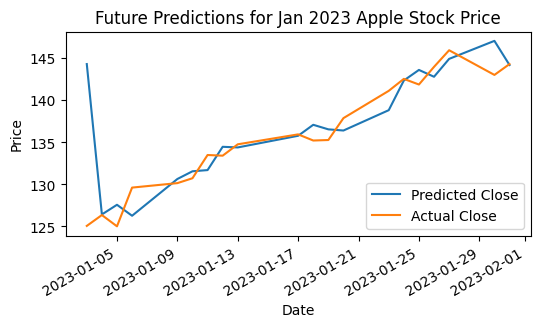

RMSE del mejor modelo de Apple: 4.620


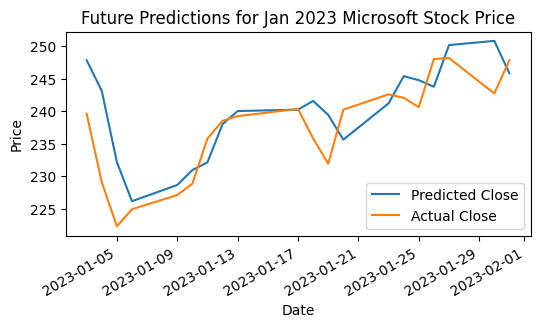

RMSE del mejor modelo de Microsoft: 5.550


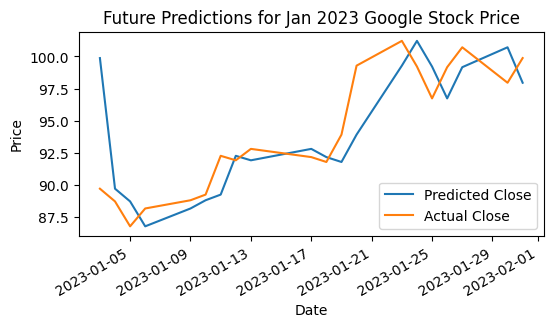

RMSE del mejor modelo de Google: 3.067


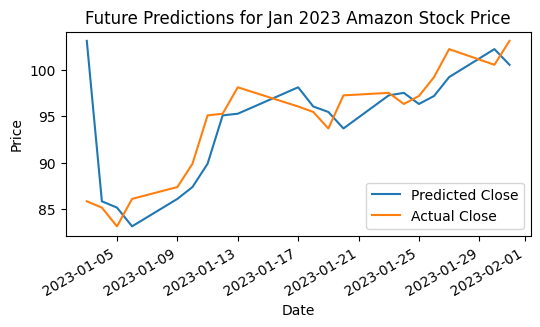

RMSE del mejor modelo de Amazon: 4.483


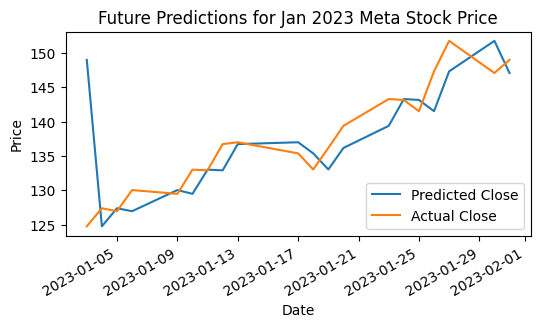

RMSE del mejor modelo de Meta: 6.149


In [18]:
def predict_with_best_model(original_df, company, lr):
    df = original_df.copy()
    X = df.drop(['Close'], axis=1)
    lr_pred = lr.predict(X)
    lr_pred = pd.DataFrame(lr_pred, index=df.index, columns=['Close'])
    lr_pred['Close'] = lr_pred['Close'].shift(1)
    lr_pred['Close'].iloc[0] = df['Close'].iloc[-1]
    lr_pred['Close'].plot(figsize=(6,3), label='Predicted Close')
    df['Close'].plot(label='Actual Close')
    plt.legend(loc='best')
    plt.title("Future Predictions for Jan 2023 " + company + " Stock Price")
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.show()
    # calculate the root mean squared error
    rmse = np.sqrt(mean_squared_error(df['Close'], lr_pred['Close']))
    print('RMSE del mejor modelo de ' + company + ': %.3f' % rmse)


predict_with_best_model(PRE_FUTURE_AAPL, 'Apple', BEST_AAPL)
predict_with_best_model(PRE_FUTURE_MSFT, 'Microsoft', BEST_MSFT)
predict_with_best_model(PRE_FUTURE_GOOG, 'Google', BEST_GOOG)
predict_with_best_model(PRE_FUTURE_AMZN, 'Amazon', BEST_AMZN)
predict_with_best_model(PRE_FUTURE_META, 'Meta', BEST_META)

## Datos interesantes sobre el proyecto

Al explorar los datos, fue interesante ver cómo cambiaron las cotizaciones bursátiles de las distintas empresas debido a la pandemia y cómo las cotizaciones bursátiles de las empresas tecnológicas se recuperaron más rápidamente que las de las demás empresas consideradas. Estos son algunos de los aspectos más destacados de la sección de exploración de datos:

- 2019: Antes de la pandemia, las acciones de la mayoría de las empresas iban relativamente bien, con Apple y Microsoft a la cabeza.
- 2020: Al inicio de la pandemia, en torno a la primavera, se produjo una caída de las cotizaciones bursátiles de todas las empresas, pero después las compañías tecnológicas como Amazon, Apple, Microsoft y Google empezaron a crecer de nuevo.
- 2021: Empresas como Google y Microsoft crecieron. En general, hubo una mejora en los precios de las acciones de todas las empresas que consideramos.

## Future work y conclusiones

El mercado bursátil ha sido siempre el tema más candente cuando se trata de prever series temporales o de intentar intuir hacia dónde se dirige el mercado en general. Es imposible encontrar la fórmula "a seguir" para predecir la dirección del mercado de valores, debido a la constante volatilidad del mercado, la incertidumbre de las variables móviles que podrían afectar a la volatilidad del mercado de valores, desde el riesgo asociado a la inestabilidad política y los factores macroeconómicos, bueno, la lista podría continuar. Sorprendentemente, estos modelos nos han dado muy buenos resultados. Han predicho con bastante precision la evolucion y tendencia del valor de los stocks. Sin embargo, si esto fuese verdad, todo el mundo sería rico. La realidad es mucho más dura, y aunque nuestro modelo refleje parcialmente un sistema tan variable como el mercado bursátil, este está lleno de aleatoriedad y estadística muy compleja que es imposible de reflejar completamente en un proyecto académico. Un punto de mejora sería dedicar más tiempo a afinar los parámetros de los distintos modelo, así como a incluir más características que puedan ser relevantes para la predicción del precio de las acciones, y revisar bien los algoritmos de aprendizaje para comprobar que están usando la información realmente necesaria.

Con estas predicciones acabamos nuestro proyecto de MLE. Durante la realización de este proyecto, hemos buscado, leido y procesado datasets para adecuarlos a nuestro objetivo concreto. Hemos generado medidas estadísticas derivadas de nuestros datos, analizandolas y visualizando distintas gráficas para poder obtener información del dominio del mundo bursátil. Hemos creado y evaluado 4 modelos de aprendizaje distintos, quedándonos con el mejor para cada caso concreto de las 5 empresas analizadas, y para finalizar hemos realizado una predicción futura de los valores de sus acciones.